In [1]:
!jupyter nbconvert gaussian_process.ipynb --to python --no-prompt

[NbConvertApp] Converting notebook gaussian_process.ipynb to python
[NbConvertApp] Writing 7767 bytes to gaussian_process.py


In [2]:
import numpy as np
import scipy.linalg as spl
import numba
import matplotlib.pyplot as plt
import IPython.display as ipyd
import ipywidgets as ipyw
import itertools

In [3]:
# Params:  A (pos. def.)
# Returns: B
# where:   A = B.T @ B
def cov_factorize(A, kind):
    if kind == 0:
        # cholesky
        B = np.linalg.cholesky(A)

    if kind == 1:
        # cholesky + noise for "almost" singular A
        I = np.eye(A.shape[0])
        B = np.linalg.cholesky(A + I / 2**20)
        
    if kind == 2:
        # sqrt formula (TODO: logm should have bad converge for almost singular matrix though...)
        B = np.real(spl.expm(spl.logm(A) / 2))
        
    if kind == 3:
        # schur decomposition (which is actually used in logm)
        A_R, A_Q = spl.schur(A)
        A_D = np.diagonal(A_R)
        A_D_sqrt = np.sqrt(np.where(A_D > 0, A_D, 0))
        B = A_Q * A_D_sqrt

    return B

def cov_sample(cov, batch=1, kind=1):
    cov_map = cov_factorize(cov, kind=kind)
    ys = cov_map @ np.random.randn(cov.shape[0], batch)
    return ys.T

def test_cov_factorize():
    x = np.linspace(0, 1, 2**9)
    cov = np.exp(- 1. * (x[:, np.newaxis] - x) ** 2)
    cov_map = cov_factorize(cov, kind=3)
    assert np.allclose(cov_map @ cov_map.T, cov)
    
test_cov_factorize()    

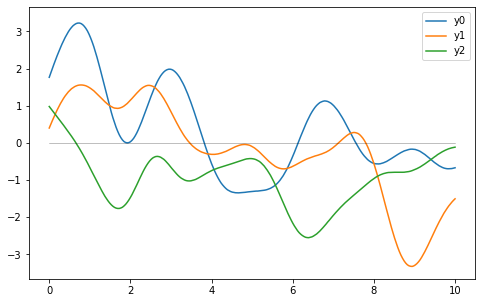

In [4]:
def gp_plot_ex1():
    x = np.linspace(0, 10, 2**8)

    # "squared exp" covariance function
    cov = np.exp(- 1. * (x[:, np.newaxis] - x) ** 2)
    ys = cov_sample(cov, batch=3)

    fig, ax = plt.subplots(figsize=(8, 5))
    for i, y in enumerate(ys):
        ax.plot(x, y, label=f"y{i}")
        
    ax.plot(x, np.zeros_like(x), color='black', alpha=.5, linewidth=0.5)

    lim = np.max(np.abs(ys)) * 1.1
    ax.set(ylim=[-lim, lim])
    ax.legend()

np.random.seed(0)
gp_plot_ex1()    

In [5]:
#
# Params:
# - cov:     f[m, m]
# - y1:      f[m]  
# - y1_mask: b[m]
#
# Returns:
# - y2_cov:  f[k, k]
# - y2_mean: f[k]
#
# Where:
# - k = m - y1_mask.sum()
#
def conditional_gaussian(cov, y1, y1_mask):
    cov11 = cov[ y1_mask, :][:,  y1_mask]
    cov12 = cov[ y1_mask, :][:, ~y1_mask]
    cov22 = cov[~y1_mask, :][:, ~y1_mask]
    cov11_inv = np.linalg.inv(cov11)
    y2_cov = cov22 - cov12.T @ cov11_inv @ cov12
    y2_mean = cov12.T @ cov11_inv @ y1
    return y2_cov, y2_mean

#
# Params:
# - cov:     f[m, m]
# - y1_mask: b[m]
#
# Returns:
# - y2_cov:      f[k, k]
# - y2_mean_map: f[k, l]
#
# Where:
# - l = y1_mask.sum()
# - k = m - l
#
def conditional_gaussian_v2(cov, y1_mask):
    cov11 = cov[ y1_mask, :][:,  y1_mask]
    cov12 = cov[ y1_mask, :][:, ~y1_mask]
    cov22 = cov[~y1_mask, :][:, ~y1_mask]
    cov11_inv = np.linalg.inv(cov11)
    y2_cov = cov22 - cov12.T @ cov11_inv @ cov12
    y2_mean_map = cov12.T @ cov11_inv
    return y2_cov, y2_mean_map

In [6]:
# Last quarter is "almost" independent from first quarter.
# Of course, this depends on how covariance function decays.
# For square exp case, |x - x'| ~ 5  =>  exp(-|x - x'|^2) ~ 1e-11
def test_conditional_gaussian_ex1():
    np.random.seed(0)
    m = 2**8
    q = m // 4
    y1_mask = np.arange(m) < q
    
    x = np.linspace(0, 10, m)
    cov = np.exp(- (x[:, np.newaxis] - x) ** 2)
    y234_cov, y234_mean_map = conditional_gaussian_v2(cov, y1_mask)
    
    assert np.allclose(
        cov[-q:, :][:, -q:],     # prior covariance
        y234_cov[-q:, :][:, -q:] # conditioned covariance
    )
    # "mean_map" actually needs more separation to get "zero" influence.
    # Note that "cov" decays quadratically compared to "mean_map" due to
    # how "cov12" is multiplied in "conditional_gaussian_v2"
    assert np.allclose(y234_mean_map[-q//8:], 0)
    
test_conditional_gaussian_ex1()

In [7]:
def gp_plot_ex2(*, y1_plot, make_y1_mask):
    m = 2**8
    x = np.linspace(0, 10, m)
    cov = np.exp(- 1. * (x[:, np.newaxis] - x) ** 2) + np.eye(x.shape[0]) / 2**20

    y1_mask = make_y1_mask(m)
    y1 = cov_sample(cov[y1_mask, :][:, y1_mask], kind=0)[0]

    y2_cov, y2_mean = conditional_gaussian(cov, y1, y1_mask)
    y2 = y2_mean + cov_sample(y2_cov, kind=0)[0]

    fig, ax = plt.subplots(figsize=(10, 6))

    getattr(ax, y1_plot)(x[ y1_mask], y1,   label='y1')
    ax.plot(x[~y1_mask], y2,      label='y2', color='C1')
    ax.plot(x[~y1_mask], y2_mean, label='y2_mean', alpha=.9, color='C3', linestyle=':')

    y2_std = np.sqrt(np.diagonal(y2_cov))
    ax.fill_between(x[~y1_mask], y2_mean - y2_std, y2_mean + y2_std,
                    alpha=.1, color='C3', label='y2_mean +- y2_std')

    ax.plot(x, np.zeros_like(x), color='black', alpha=.5, linewidth=0.5)
    y = np.concatenate((y1, y2))
    lim = np.max(np.abs(y)) * 1.1
    lim = 3
    ax.set(ylim=[-lim, lim])
    ax.legend()

@ipyw.interact(start=ipyw.IntText(value=50, step=10), end=ipyw.IntText(value=100, step=10))
def _(start, end):
    np.random.seed(2)
    gp_plot_ex2(
        y1_plot='plot',
        make_y1_mask=lambda m: (start <= np.arange(m)) & (np.arange(m) < end))

interactive(children=(IntText(value=50, description='start', step=10), IntText(value=100, description='end', s…

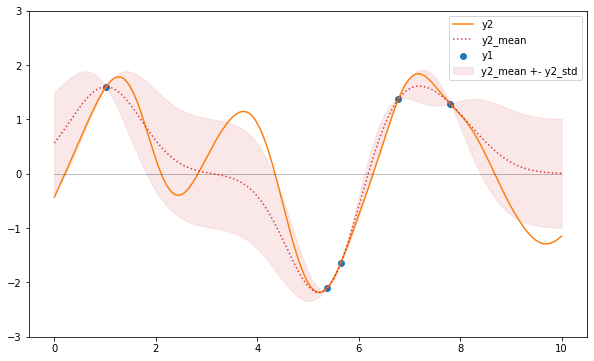

In [8]:
def random__y1_mask(m, n):
    y1_mask = np.zeros(m, dtype=np.bool)
    y1_mask[np.random.choice(np.arange(m), n, replace=False)] = True
    return y1_mask

np.random.seed(11)
gp_plot_ex2(
    y1_plot='scatter',
    make_y1_mask=lambda m: random__y1_mask(m, 5))

In [9]:
import scipy.spatial.distance as spsd
import mpl_toolkits.mplot3d # for side-effect which updates matplotlib.projections.projection_registry

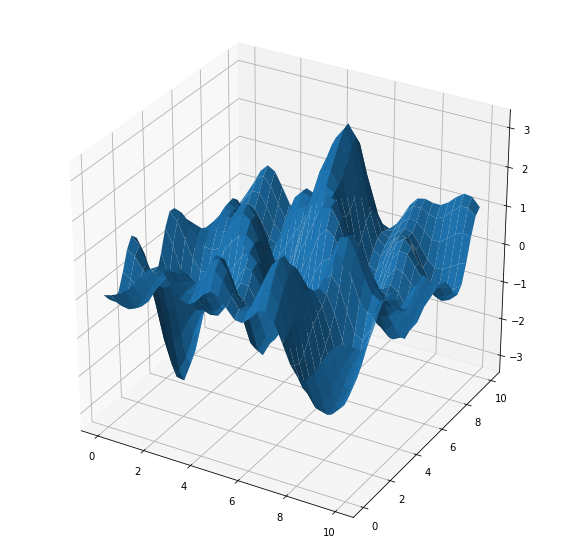

In [10]:
#
# 2D domain
#
def gp_plot_ex3():
    m = 2**5
    x1 = np.linspace(0, 10, m)
    x2 = np.linspace(0, 10, m)
    x1_, x2_ = np.meshgrid(x1, x2)
    x = np.concatenate((x1_.reshape(-1, 1), x2_.reshape(-1, 1)), axis=-1)
    
    cov_slim = np.exp(- 1. * spsd.pdist(x) ** 2)
    cov = spsd.squareform(cov_slim)
    
    # Cholesky (kind=1) fails, so use my log formula
    y = cov_sample(cov, batch=1, kind=2)[0]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='3d'))
    ax.plot_surface(x1_, x2_, y.reshape(m, m))
    lim = np.max(np.abs(y)) * 1.1
    ax.set(zlim=[-lim, lim])

np.random.seed(0)
gp_plot_ex3()

In [11]:
#
# Patch-wise conditioned sampling approx.
# - patch up domains by conditioning over overlapped regions
#

#
# 1D domain case
#
def gp_plot_ex4():
    m2 = 2**8
    m = m2 // 2
    x = np.linspace(0, 10, m2)
    init_mask = np.arange(m2) < m
    cov_orig = np.exp(- 0.5 * (x[:, np.newaxis] - x) ** 2) + np.eye(m2) / 2**20
    cov1 = cov_orig[:m, :][:, :m]
    cov2, mean_map = conditional_gaussian_v2(cov_orig, init_mask)
    
    # Initial patch is special
    cov_init_factor = cov_factorize(cov1, kind=0)
    y_init = cov_init_factor @ np.random.randn(m)

    # Other patch will be generated based on these data
    cov_factor = cov_factorize(cov2, kind=0)
    mean = mean_map @ y_init

    # Generate iteratively by only updating "mean"
    def sample_generator():
        nonlocal mean
        for i in itertools.count():
            x_ = x[:m] + x[m] * i
            y_ = mean + cov_factor @ np.random.randn(m)
            mean = mean_map @ y_
            yield x_, y_    

    generator = sample_generator()
    
    # Keep N patches
    N = 10
    xys = list(itertools.islice(generator, N))

    # Plotting
    fig, ax = plt.subplots(figsize=(18, 6))
    fig.clear() # workaround ion/ioff bug
    
    
    def draw():
        fig.add_axes(ax)
        for x_, y_ in xys:
            ax.plot(x_, y_, color='C0')
        xlim_auto = ax.get_xlim()
        ax.plot(xlim_auto, [0, 0], color='black', alpha=.5, linewidth=0.5)
        lim = 3
        ax.set(xlim=xlim_auto, ylim=[-lim, lim])
        ipyd.display(fig)
        ax.clear()
        fig.delaxes(ax)

    @ipyw.interact_manual()
    def _():
        xys.pop(0)
        xys.append(next(generator))
        draw()
    
gp_plot_ex4()

<Figure size 1296x432 with 0 Axes>

interactive(children=(Button(description='Run Interact', style=ButtonStyle()), Output()), _dom_classes=('widge…